# Kapitel 6.10: Anschaulichkeit

Das Notebook ergänzt Kapitel 6.10 'Anschaulichkeit'.

# Import

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from resources_statistics import *
from resources_geschichtslyrik import *

from tqdm.notebook import tqdm

In [2]:
meta = pd.read_json(r"../resources/meta.json")

# Korpora

### Korpora erstellen

In [3]:
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_anth_bin = binarize_meta(meta_anth)

In [4]:
modcanon_authors = ['Hofmannsthal, Hugo von', 'Rilke, Rainer Maria', 'George, Stefan', 'Heym, Georg']

meta_modcanon = (
    meta
    .query("author in @modcanon_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [5]:
muench_authors = ['Münchhausen, Börries von', 'Miegel, Agnes', 'Strauß und Torney, Lulu von']

meta_muench = (
    meta
    .query("author in @muench_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [6]:
sub_df = pd.DataFrame()
sub_names = ['Anthologien', 'Kanonisierte Moderne', 'Münchhausen-Kreis']
sub_metas = [meta_anth, meta_modcanon, meta_muench]

### Merkmale berechnen

In [7]:
for this_name, this_meta in zip(sub_names, sub_metas):
    sub_df.loc[this_name, 'Jahr'] = round(this_meta['year'].mean(), 0)
    sub_df.loc[this_name, 'Texte'] = this_meta.shape[0]

    sub_df.loc[this_name, 'konkret_high'] = this_meta.query("konkretheit == 1").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, 'konkret_med'] = this_meta.query("konkretheit == 0.5").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, 'konkret_low'] = this_meta.query("konkretheit == 0").shape[0]/this_meta.shape[0]

In [8]:
round(sub_df, 4)

,Jahr,Texte,konkret_high,konkret_med,konkret_low
Anthologien,1875.0,1850.0,0.8178,0.1686,0.0135
Kanonisierte Moderne,1903.0,113.0,0.7965,0.1504,0.0531
Münchhausen-Kreis,1905.0,140.0,0.9071,0.0929,0.0000


# Zeitverlauf

In [9]:
ts = pd.DataFrame()
ts.index = pd.Series(range(1850, 1919), name = 'year')

In [10]:
ts['text_count'] = meta_anth.groupby('year').size()
ts['text_count'] = ts['text_count'].fillna(0)
ts['text_sum'] = smooth(ts['text_count'], mode = 'sum')

In [11]:
ts['konkret_high_count'] = [meta_anth.query("year == @x and konkretheit == 1").shape[0] for x in ts.index]
ts['konkret_high_sum'] = smooth(ts['konkret_high_count'], mode = 'sum')
ts['konkret_high_share_smoothed'] = ts['konkret_high_sum']/ts['text_sum']

ts['konkret_med_count'] = [meta_anth.query("year == @x and konkretheit == 0.5").shape[0] for x in ts.index]
ts['konkret_med_sum'] = smooth(ts['konkret_med_count'], mode = 'sum')
ts['konkret_med_share_smoothed'] = ts['konkret_med_sum']/ts['text_sum']

ts['konkret_low_count'] = [meta_anth.query("year == @x and konkretheit == 0").shape[0] for x in ts.index]
ts['konkret_low_sum'] = smooth(ts['konkret_low_count'], mode = 'sum')
ts['konkret_low_share_smoothed'] = ts['konkret_low_sum']/ts['text_sum']

# Konkretheit

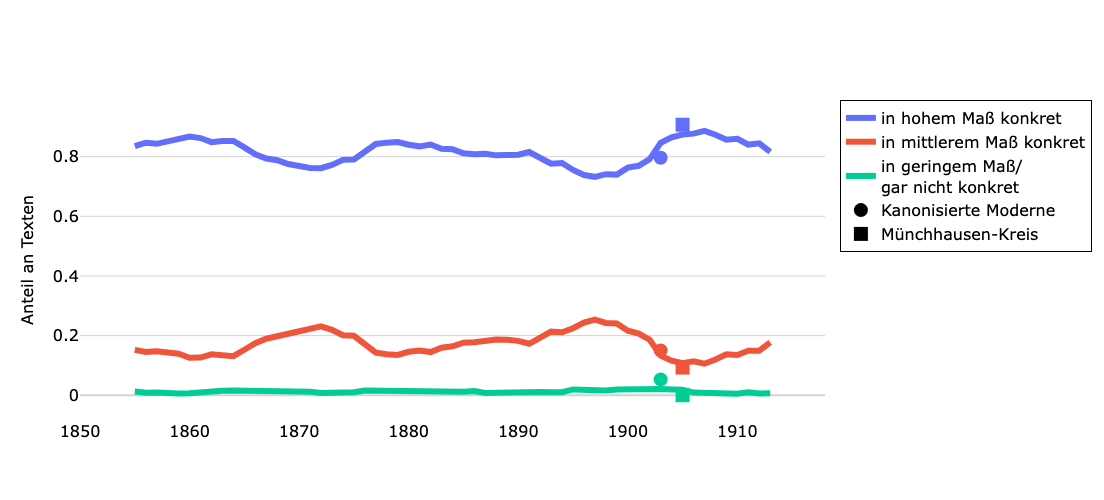

In [41]:
meta_plot = ts[[
    'konkret_high_share_smoothed', 
    'konkret_med_share_smoothed', 
    'konkret_low_share_smoothed',
]]
meta_plot.columns = [
    'in hohem Maß konkret', 
    'in mittlerem Maß konkret', 
    'in geringem Maß/<br>gar nicht konkret',
]
save_ts_data(meta_plot, prefix='06_10_Konkretheit_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['konkret_high', 'konkret_med', 'konkret_low',]
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.10 Konkretheit im Zeitverlauf.pdf")
fig.show()

In [13]:
# Texte 1870/71
meta_1870 = meta_anth_bin.query("1870 <= year <= 1871").copy()
meta_1870['krieg_gegenwart'] = [1 if x == 1 and y == 1 else 0 for x, y in zip(meta_1870['krieg'], meta_1870['gegenwartsdominant'])]
contingency_table = pd.crosstab(meta_1870['in_hohem_mass_konkret'], meta_1870['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

krieg_gegenwart         0   1
in_hohem_mass_konkret        
0                      20  20
1                      45  24


chi2   : 1.8447016887098413
chi2 p : 0.17440087889051595
phi    : 0.14948985918580535


In [14]:
# Texte 1897/98
meta_1870 = meta_anth_bin.query("1897 <= year <= 1898").copy()
meta_1870['wilhelm_bismarck'] = [1 if 'Wilhelm I.' in x or 'Bismarck' in x else 0 for x in meta_1870['entity_full']]
contingency_table = pd.crosstab(meta_1870['in_hohem_mass_konkret'], meta_1870['wilhelm_bismarck'])

print(contingency_table)
print(f"fisher   : {fisher_exact(contingency_table)[0]}")
print(f"fisher p : {fisher_exact(contingency_table)[1]}")
print(f"phi      : {get_phi(np.array(contingency_table))}")
print("\n")

wilhelm_bismarck        0   1
in_hohem_mass_konkret        
0                       4  10
1                      16   1
fisher   : 0.025
fisher p : 0.0003514371846334897
phi      : 0.6817494235765679




In [15]:
# Texte 1914/18
meta_1870 = meta_anth_bin.query("1914 <= year <= 1918").copy()
meta_1870['krieg_gegenwart'] = [1 if x == 1 and y == 1 else 0 for x, y in zip(meta_1870['krieg'], meta_1870['gegenwartsdominant'])]
contingency_table = pd.crosstab(meta_1870['in_hohem_mass_konkret'], meta_1870['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"fisher   : {fisher_exact(contingency_table)[0]}")
print(f"fisher p : {fisher_exact(contingency_table)[1]}")
print(f"phi      : {get_phi(np.array(contingency_table))}")

krieg_gegenwart         0   1
in_hohem_mass_konkret        
0                       6   6
1                      28  10


fisher   : 0.35714285714285715
fisher p : 0.16267853155304496
phi      : 0.21684124109359199


In [16]:
main_feature = 'in_hohem_mass_konkret'

In [17]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

in_hohem_mass_konkret             1.000000
konkretheit                       0.965483
wissen_ergaenzend                 0.457554
sprechakt_erzaehlen_vorhanden     0.449825
ballade                           0.430865
ereignis                          0.352042
kleinraum_count                   0.262803
entity_count                      0.226377
unbekanntes_individuum_count      0.189940
entity_neutral                    0.188081
words                             0.171297
unbekanntes_individuum_positiv    0.147521
stoffgebiet_neutral               0.135998
nation_volk_d_negativ             0.127923
bekanntes_individuum_count        0.119686
geschichtsauffassung_negativ      0.115221
empirisch                         0.110304
mittelalter                       0.104597
objektmarker_vorhanden            0.101310
fixierbarkeit                     0.097138
Name: in_hohem_mass_konkret, dtype: float64

In [18]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

wissen_identisch                       -0.596218
sprechakt_behaupten_vorhanden          -0.496733
zustand                                -0.386812
nogenre                                -0.354197
gegenwartsbezug                        -0.306742
sprechinstanz_nicht_in_vergangenheit   -0.286401
sprechinstanz_markiert                 -0.271703
liebe_positiv                          -0.256277
nationalismus                          -0.244200
sprechakte_count                       -0.241797
wissen                                 -0.220195
ueberlieferung_positiv                 -0.201473
gegenwartsdominant                     -0.196716
theoretisch                            -0.186357
sonett                                 -0.164711
ueberlieferung                         -0.162480
sprechakt_beschreiben_vorhanden        -0.162004
nation_volk_d                          -0.153661
zeitebenen                             -0.147513
futur_vorhanden                        -0.144724
Name: in_hohem_mass_

In [19]:
threshold = 0.2

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [20]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [21]:
directly_related = [
    'sprechinstanz_nicht_in_vergangenheit', # related to gegenwartsbezug+sprechinstanz_markiert
    'wissen_identisch', # related to wissen_ergaenzend
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
ballade,0.11,36/337,0.66,1000/1513,0.51,0.51,0.55,0.59,0.59,343.44,0.0,0.0,0.43,36.0,148.28
wissen_ergaenzend,0.33,110/337,0.84,1273/1513,0.46,0.46,0.51,0.57,0.57,387.31,0.0,0.0,0.46,110.0,85.07
sprechakt_erzaehlen_vorhanden,0.36,123/337,0.86,1297/1513,0.43,0.44,0.49,0.55,0.55,374.33,0.0,0.0,0.45,123.0,78.33
ereignis,0.46,156/337,0.84,1277/1513,0.33,0.32,0.38,0.44,0.44,229.28,0.0,0.0,0.35,156.0,75.96
nationalismus,0.31,106/337,0.10,147/1513,-0.27,-0.27,-0.22,-0.17,-0.17,110.32,0.0,0.0,0.24,106.0,46.09
ueberlieferung_positiv,0.72,92/128,0.50,152/304,-0.31,-0.31,-0.22,-0.12,-0.13,17.54,0.0,0.0,0.20,36.0,55.70
sprechinstanz_markiert,0.72,244/337,0.37,567/1513,-0.40,-0.40,-0.35,-0.30,-0.30,136.57,0.0,0.0,0.27,93.0,147.73
gegenwartsbezug,0.58,197/337,0.22,339/1513,-0.41,-0.42,-0.36,-0.30,-0.30,174.07,0.0,0.0,0.31,140.0,97.64
nogenre,0.54,183/337,0.16,239/1513,-0.44,-0.44,-0.39,-0.33,-0.32,232.09,0.0,0.0,0.35,154.0,76.87
zustand,0.82,276/337,0.33,492/1513,-0.54,-0.54,-0.49,-0.45,-0.45,276.80,0.0,0.0,0.39,61.0,139.90


In [22]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
unbekanntes_individuum_positiv,0.05,1/19,0.35,216/612,0.18,0.19,0.30,0.41,0.38,7.37,0.01,0.01,0.11,1.0,6.53
entity_neutral,0.17,97/574,0.32,1060/3342,0.11,0.11,0.15,0.18,0.18,51.68,0.00,0.00,0.11,97.0,169.59
stoffgebiet_neutral,0.08,36/450,0.21,446/2090,0.10,0.10,0.13,0.16,0.16,42.85,0.00,0.00,0.13,36.0,85.39
kollektiv_negativ,0.21,43/207,0.26,225/857,-0.01,-0.01,0.05,0.12,0.12,2.66,0.10,0.11,0.05,43.0,52.14
stoffgebiet_negativ,0.17,77/450,0.22,459/2090,0.01,0.01,0.05,0.09,0.08,5.23,0.02,0.02,0.05,77.0,94.96
bekanntes_individuum_negativ,0.10,30/295,0.14,246/1730,0.00,0.00,0.04,0.08,0.08,3.51,0.06,0.07,0.04,30.0,40.21
entity_negativ,0.15,85/574,0.17,559/3342,-0.01,-0.01,0.02,0.05,0.05,1.31,0.25,0.27,0.02,85.0,94.40
stoffgebiet_ambivalent,0.12,53/450,0.14,285/2090,-0.02,-0.01,0.02,0.05,0.05,1.11,0.29,0.32,0.02,53.0,59.88
entity_ambivalent,0.05,31/574,0.06,213/3342,-0.01,-0.01,0.01,0.03,0.03,0.79,0.37,0.40,0.01,31.0,35.77
unbekanntes_individuum_negativ,0.21,4/19,0.13,77/612,-0.29,-0.27,-0.08,0.10,0.08,1.18,0.28,0.29,0.04,4.0,2.44


In [23]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
ereignis,0.485,115/237,0.870,965/1109,0.385,0.000,0.368,0.410,41/100,0.772,312/404,0.362,0.0,0.315,-0.023,-0.053
zustand,0.797,189/237,0.294,326/1109,-0.504,0.000,0.395,0.870,87/100,0.411,166/404,-0.459,0.0,0.366,0.044,-0.028
ballade,0.143,34/237,0.702,778/1109,0.558,0.000,0.434,0.020,2/100,0.550,222/404,0.530,0.0,0.425,-0.029,-0.010
sprechakt_erzaehlen_vorhanden,0.388,92/237,0.873,968/1109,0.485,0.000,0.451,0.310,31/100,0.814,329/404,0.504,0.0,0.445,0.020,-0.006
nogenre,0.498,118/237,0.129,143/1109,-0.369,0.000,0.355,0.650,65/100,0.238,96/404,-0.412,0.0,0.353,-0.043,-0.003
wissen_ergaenzend,0.338,80/237,0.842,934/1109,0.505,0.000,0.446,0.300,30/100,0.839,339/404,0.539,0.0,0.485,0.034,0.040
gegenwartsbezug,0.578,137/237,0.229,254/1109,-0.349,0.000,0.293,0.600,60/100,0.210,85/404,-0.390,0.0,0.343,-0.041,0.050
sprechinstanz_markiert,0.713,169/237,0.380,421/1109,-0.333,0.000,0.256,0.750,75/100,0.361,146/404,-0.389,0.0,0.312,-0.055,0.056
nationalismus,0.295,70/237,0.100,111/1109,-0.195,0.000,0.218,0.360,36/100,0.089,36/404,-0.271,0.0,0.309,-0.076,0.091
sprechakt_behaupten_vorhanden,0.544,129/237,0.095,105/1109,-0.450,0.000,0.452,0.720,72/100,0.097,39/404,-0.623,0.0,0.600,-0.174,0.148


In [24]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = [x for x in cont_comp_features if x != 'konkretheit']
)

In [25]:
unsuited = ['wissen']
results_filtered = (
    results
    .query("index not in @unsuited")
    .query("mannwhitneyu_p < 0.05 and (pointbiserialr_corr >= @threshold or pointbiserialr_corr <= -@threshold)")
    .sort_values(by = 'pointbiserialr_corr', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
kleinraum_count,0.34,0.68 [230/337],0.3 [101/337],0.01 [5/337],0.0 [1/337],0.0 [0/337],0.73,0.32 [488/1513],0.63 [952/1513],0.04 [68/1513],...,0.26,0.0,0.0,-0.72,162363.0,0.0,0.33,0.33,0.46,0.46
entity_count,1.70,0.0 [0/337],0.48 [163/337],0.36 [123/337],0.12 [42/337],0.03 [9/337],2.21,0.0 [0/1513],0.2 [296/1513],0.47 [710/1513],...,0.23,0.0,0.0,-0.61,168397.0,0.0,0.41,0.41,0.60,0.59
sprechakte_count,1.60,0.0 [0/337],0.45 [152/337],0.5 [170/337],0.04 [14/337],0.0 [1/337],1.27,0.0 [0/1513],0.74 [1118/1513],0.25 [374/1513],...,-0.24,0.0,0.0,0.60,329366.0,0.0,-0.38,-0.39,-0.26,-0.25


In [26]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='pointbiserialr_corr', ascending=False), 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
wissen,0.4,0.15 [7/48],0.62 [30/48],0.0 [0/48],0.0 [0/48],0.0 [0/48],-0.04,0.17 [20/115],0.39 [45/115],0.0 [0/115],...,-0.22,0.0,0.0,0.5,3470.0,0.0,-0.74,-0.74,-0.14,-0.15


In [27]:
meta_plot = meta_anth_bin.copy()

for cont_comp_feature in results_filtered.index:
    mean_main = meta_plot[meta_plot[main_feature] == 1][cont_comp_feature].mean()
    mean_notmain = meta_plot[meta_plot[main_feature] == 0][cont_comp_feature].mean()
    label_main = f"In hohem Maß konkret<br>(Mittelwert = {round(mean_main, 2)})"
    label_notmain = f"Nicht in hohem Maß konkret<br>(Mittelwert = {round(mean_notmain, 2)})"
    meta_plot['plot_legend'] = [label_main if x == 1 else label_notmain for x in meta_plot[main_feature]]
        
    fig = px.histogram(
        meta_plot,
        x = cont_comp_feature,
        color = 'plot_legend',
        histnorm = 'probability density',
        barmode = 'group',
        labels = {'plot_legend' : '', 
                  'sprechakte_count' : 'Anzahl Sprechakte',
                  'entity_count' : 'Anzahl Entitäten',
                  'kleinraum_count' : 'Anzahl behandelte Kleinräume',
                 }
    )

    fig.update_layout(
        width = 700, height = 300,
        yaxis_title="Anteil",
        xaxis=dict(tickfont=dict(size=14), titlefont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=14), titlefont=dict(size=14)),
        legend=dict(font = dict(size=14), x=0.52, y = 0.92),
        bargap=0.1
    )
    fig = update_fig_for_publication(fig)
    fig.write_image(f"plots/6.10 Konkretheit – {cont_comp_feature}.pdf")
    fig.show()

In [28]:
result_categories = ['wenn_nicht', 'wenn_ja', 'mannwhitneyu_p', 'pointbiserialr_corr',]

results_a = relations_bincont(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_bincont(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_corrs'] = results_merged['pointbiserialr_corr_1885'] - results_merged['pointbiserialr_corr_1850']

round(results_merged.sort_values(by = 'diff_of_corrs'), 3)

,wenn_nicht_1850,wenn_ja_1850,mannwhitneyu_p_1850,pointbiserialr_corr_1850,wenn_nicht_1885,wenn_ja_1885,mannwhitneyu_p_1885,pointbiserialr_corr_1885,diff_of_corrs
sprechakte_count,1.557,1.254,0.0,-0.231,1.69,1.332,0.0,-0.264,-0.034
entity_count,1.747,2.271,0.0,0.233,1.60,2.040,0.0,0.204,-0.030
kleinraum_count,0.397,0.761,0.0,0.245,0.20,0.649,0.0,0.303,0.058


In [29]:
meta_anth_kombi = meta_anth_bin.copy()
meta_anth_kombi['kombi'] = 0
for i, element in enumerate(meta_anth_kombi.iloc):
    if element['sprechakt_erzaehlen_vorhanden'] == 1:
        if element['ballade'] == 1:
            if element['ereignis'] == 1:
                if element['wissen_ergaenzend'] == 1:
                    if element['kleinraum_count'] >= 1:
                        if element['entity_count'] >= 2:
                            meta_anth_kombi.at[i, 'kombi'] = 1
                            
meta_anth_kombi['kombi'] = meta_anth_kombi['kombi'].fillna(0)

results = relations_binbin(
    meta = meta_anth_kombi, 
    main_feature = 'kombi',
    comp_features = ['in_hohem_mass_konkret']
)

round(results, 2)[['wenn_ja_detail', 'wenn_ja']]

,wenn_ja_detail,wenn_ja
in_hohem_mass_konkret,592/600,0.99


In [30]:
meta_anth_kombi = meta_anth_bin.copy()
meta_anth_kombi['kombi'] = 0
for i, element in enumerate(meta_anth_bin.iloc):
    if element['sprechinstanz_markiert'] == 1:
        if element['sprechakte_count'] >= 2:
            if element['sprechakt_behaupten_vorhanden'] == 1:
                if element['gegenwartsbezug'] == 1:
                    if element['nationalismus'] == 1:
                        meta_anth_kombi.at[i, 'kombi'] = 1
                            
meta_anth_kombi['kombi'] = meta_anth_kombi['kombi'].fillna(0)

results = relations_binbin(
    meta = meta_anth_kombi, 
    main_feature = 'kombi',
    comp_features = ['in_hohem_mass_konkret']
)

round(results, 2)[['wenn_ja_detail', 'wenn_ja']]

,wenn_ja_detail,wenn_ja
in_hohem_mass_konkret,19/63,0.3


# Weiteres

In [31]:
pd.crosstab(meta_anth_bin['sprechinstanz_markiert'], meta_anth_bin['in_hohem_mass_konkret'])

in_hohem_mass_konkret,0,1
sprechinstanz_markiert,,
0.0,93,946
1.0,244,567


In [32]:
meta_markiert = meta_anth_bin.query("sprechinstanz_markiert == 1")

results = relations_binbin(
    meta = meta_markiert, 
    main_feature = 'rollengedicht',
    comp_features = ['in_hohem_mass_konkret']
)

round(results, 2).T

,in_hohem_mass_konkret
wenn_nicht,0.67
wenn_nicht_detail,386/574
wenn_ja,0.76
wenn_ja_detail,181/237
diff_low_bootstrap,0.03
diff_low,0.02
diff,0.09
diff_high,0.16
diff_high_bootstrap,0.16
chi2,6.64


In [33]:
meta_muench_bin = binarize_meta(meta_muench)
meta_modcanon_bin = binarize_meta(meta_modcanon)
meta_all = pd.concat([meta_anth_bin, meta_muench_bin, meta_modcanon_bin])

results = relations_binbin(
    meta = meta_all, 
    main_feature = 'verfremdung',
    comp_features = ['in_hohem_mass_konkret']
)

round(results, 3).T

,in_hohem_mass_konkret
wenn_nicht,0.828
wenn_nicht_detail,1698/2050
wenn_ja,0.604
wenn_ja_detail,32/53
diff_low_bootstrap,-0.355
diff_low,-0.357
diff,-0.225
diff_high,-0.092
diff_high_bootstrap,-0.088
chi2,17.849


In [34]:
for i, element in enumerate(meta_anth.iloc):
    if str(element['text_bestocr']) != 'None' and str(element['text_bestocr']) != 'nan':
        text = ' '.join(element['text_normalized_bestocr'])
        if ' minne ' in text or ' minnen ' in text:
            meta_anth.at[i, 'minne'] = 1
            
meta_anth['minne'].sum()

36.0

In [35]:
texts_start = 1850
texts_end = 1918
only_geschichtslyrik = True
anthology_start = 1850
anthology_end = 1918
min_text_count = 20

In [36]:
anthology_info = pd.read_csv(r"../resources/more/anthology_info.csv", sep=";", header=1)
anthology_info = anthology_info.rename(columns={"‚Für Schule und Haus‘" : 'Schule_Haus'})
anthology_schule = anthology_info.query("Schule == 1")['ID'].tolist()

anthology_df = pd.DataFrame()
for anthology in meta.query("anthology_year_used_ed <= 2000")['anthology'].unique():
    anthology_meta = meta.query("anthology == @anthology")
    anthology_time_meta = anthology_meta.query("@texts_start <= year <= @texts_end")
    if only_geschichtslyrik:
        anthology_time_meta = anthology_time_meta.query("geschichtslyrik == 1")
    anthology_df.at[anthology, 'anthology_year'] = anthology_meta['anthology_year_used_ed'].tolist()[0]
    anthology_df.at[anthology, 'anthology_schule'] = 'Schule' if anthology in anthology_schule else 'Nicht Schule'
    anthology_df.at[anthology, 'annotated_count'] = anthology_time_meta.query("annotated").shape[0]
    anthology_df.at[anthology, 'konkret_count'] = anthology_time_meta.query("konkretheit == 1").shape[0]
anthology_df['konkret_share'] = anthology_df['konkret_count']/anthology_df['annotated_count']

In [37]:
meta_plot = anthology_df.query("@anthology_start <= anthology_year <= @anthology_end")
meta_plot = anthology_df.query("annotated_count >= @min_text_count")

px.box(
    meta_plot,
    x = 'anthology_schule',
    y = 'konkret_share',
    points = 'all',
    hover_data = [meta_plot.index],
    labels = {'konkret_share' : 'Anteil Texte, die in hohem Maß konkret sind', 'anthology_schule' : 'Anthologie-Typ'}
)

In [38]:
meta_plot['anthology_schule'].value_counts()

anthology_schule
Schule          29
Nicht Schule    22
Name: count, dtype: int64

In [39]:
ttest_results = ttest_ind(
    meta_plot.query("anthology_schule == 'Schule'")['konkret_share'],
    meta_plot.query("anthology_schule == 'Nicht Schule'")['konkret_share'],
)

ttest_results

TtestResult(statistic=-1.598610358170376, pvalue=0.11633641636602202, df=49.0)

In [40]:
ttest_results.confidence_interval()

ConfidenceInterval(low=-0.09866144977306726, high=0.011237335135064669)